# Function for Basic Linear Regression on Cluster Plot
## Example Parameter: Avg Leaf Nitrogen Concentration (LNC) vs Leaf Carbon Nitrogen Ratio (LCN)
#### Author: Sofia Ingersoll

##### Loading environment settings

In [1]:
# moved the libraries that were here into utils.py because they're essential
# xarray is required to run the utils import line
import xarray as xr
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

Calling the machine learning utils.py `ml_utils.py` located in this ML folder

In [2]:
# import libraries & data pre-processing functions from utils.py
from ml_utils import *

### Leaf Carbon : Nitrogen Data 

**At this point in time, I am unable to plot this data because it contains NaN**

This will come in handy later when we want to plot trends overtime.


In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----     load data stored in casper     ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#-------Dummy Parameter Data---------
# x variable data for plotting
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
# the only dimension here is the 'member' aka file index id [LCH0001-500]
# convert to data set
params = xr.Dataset(df)

# the only dimension here is the 'member' aka file index id [LCH0001-500]
params

#-------Leaf Carbon : Nitrogen Data---------
# subsetting for leafcn
leafcn = params['leafcn']

##### Request additional processing power from server

In [3]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 40)

In [4]:
# apply peer2peer network communication across multiple devices
client.cluster

PBSCluster(50b24d8d, 'tcp://128.117.208.92:38969', workers=37, threads=37, memory=344.47 GiB)

## Loading a Cluster of 500 files
The data files are located in `/glade/campaign/cgd/tss/projects/PPE/PPEn11_LHC/transient/hist/`

The 2005-2010 monthly output files have the form:
`PPEn11_transient_LHC0001.clm2.h0.2005-02-01-00000.nc`

We're interested in files spanning from:
`LHC0001 to LHC0500`

In [6]:
da = read_all_simulations('LNC')

## Wrangling Cluster for Global Avg with properly weighted dimensions (time & gridcell) 

Leaf Carbon to Nitrogen Ratio Read & Wrangle

### Applying data processing functions from utils
At this point in time, only the `fix_time()` function may be successfully applied to the cluster ensemble.

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----   parameter wrangling    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# apply the bug fixing & dim. reduction functions 

# feb. ncar time bug
da = fix_time(da)

# convert xr.ds to xr.da
da = da['LNC']

# weight gridcell dim by global land area
da_global = weight_landarea_gridcells(da,landarea)

# weight time dim by days in month
da_global_ann = yearly_weighted_average(da_global)

# take global avg for param over year dimension
lnc = da_global_ann.mean(dim='year')

In [8]:
lnc

<xarray.DataArray (ens: 500)>
dask.array<mean_agg-aggregate, shape=(500,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Dimensions without coordinates: ens

### Visualize Cluster Plot with Linear Regression
I confirmed that the leafcn data provided and LNC are the same length, but it's not running. I am going to create a data array from the cluster files read in 

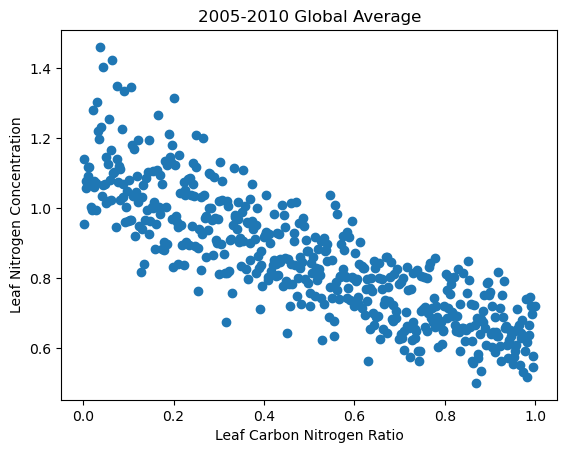

In [9]:
plt.scatter(x = leafcn,
            y = lnc)

# Set plot labels and title
plt.xlabel('Leaf Carbon Nitrogen Ratio')
plt.ylabel('Leaf Nitrogen Concentration')
plt.title('2005-2010 Global Average')

# Show the plot
plt.show()

### Functions

#### Function for user selected variable & parameter subsetting, wrangling, & plotting
Here we can see greater definition regarding the shape of the points. There seems to be less of a linear relationship than the one observed above. However, the x-axis is not wihtin hte same bounds and this is concerning.

Also, need to create a list of nicely written parameter and variable names to call from for an f str in the x & y labels.

In [5]:
#-------Dummy Parameter Data---------
# x variable data for plotting
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
# the only dimension here is the 'member' aka file index id [LCH0001-500]
# convert to data set
params = xr.Dataset(df)

In [12]:
params

<xarray.Dataset>
Dimensions:              (member: 500)
Coordinates:
  * member               (member) object 'LHC0001' 'LHC0002' ... 'LHC0500'
Data variables: (12/32)
    FUN_fracfixers       (member) float64 0.7783 0.3193 0.8768 ... 0.2621 0.4221
    KCN                  (member) float64 0.358 0.5488 0.2108 ... 0.9123 0.8392
    a_fix                (member) float64 0.255 0.6302 0.6621 ... 0.5339 0.1443
    crit_dayl            (member) float64 0.4012 0.27 0.3534 ... 0.9974 0.6571
    d_max                (member) float64 0.7978 0.5361 0.1409 ... 0.9076 0.4009
    fff                  (member) float64 0.1301 0.6792 ... 0.9918 0.02798
    ...                   ...
    stem_leaf            (member) float64 0.1138 0.1273 0.25 ... 0.3328 0.347
    sucsat_sf            (member) float64 0.7982 0.3947 0.1681 ... 0.3526 0.6515
    theta_cj             (member) float64 0.03646 0.09374 ... 0.8429 0.5055
    tpu25ratio           (member) float64 0.3936 0.04108 0.8197 ... 0.716 0.2124
    tpuse_sf             (member) float64 0.07896 0.2756 0.8401 ... 0.353 0.3634
    wc2wjb0              (member) float64 0.6846 0.8785 0.9519 ... 0.3581 0.1567

In [28]:
#-------Dummy Parameter Data---------
# x variable data for plotting
df = pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
# the only dimension here is the 'member' aka file index id [LCH0001-500]
# convert to data set
params = xr.Dataset(df)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    User Selected Plotting Funct    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def subset_and_plot_cluster(param, var):
    '''describe the relationship between the selected variable 
    and parameter(s) between 2005-2010. output a
    cluster plot averaged by year.'''

    # Read in and wrangle user selected parameter cluster
    param_avg  = params[param]

    
    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations(var)
    # feb. ncar time bug
    da = fix_time(da_v)
    # convert xr.ds to xr.da
    da = da[var]
    # weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # take global avg for variable over year dimension
    var_avg = da_global_ann.mean(dim='year')


    # Plotting
    plt.scatter(y=var_avg, color = '#62c900ff', alpha = 0.8)
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel(var)
    plt.title('2005-2010 Global Average')
    # Show the plot
    plt.show()

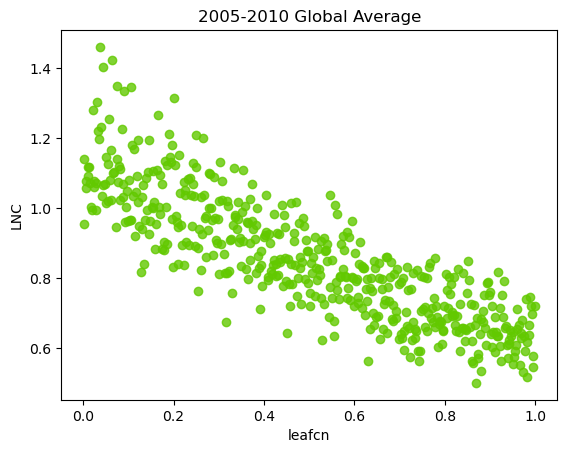

In [29]:
# Example usage:
subset_and_plot_cluster('leafcn', 'LNC')

#### Function including GPR line for plotting

Overfitting issue likely caused by simplistic relationship

In [45]:
def plot_gpr(param, var):
    '''describe the relationship between the selected variable 
    and parameter(s) between 2005-2010. output a
    cluster plot averaged by year with Gaussian Process Regression.'''

    # Read in and wrangle user selected parameter cluster
    param_avg  = params[param]

    
    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations(var)
    # feb. ncar time bug
    da = fix_time(da_v)
    # convert xr.ds to xr.da
    da = da[var]
    # weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # take global avg for variable over year dimension
    var_avg = da_global_ann.mean(dim='year')

    # Prepare data for GPR
    X = param_avg.values.reshape(-1, 1)  # Reshape to column vector
    y = var_avg.values

    # Define the kernel for GPR
    kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))

    # Initialize and fit Gaussian Process Regression model
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10#, random_state=0
                                  )
    gpr.fit(X, y)

    # Generate data for plotting GPR predictions
    x_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred, sigma = gpr.predict(x_pred, return_std=True)

    # Plotting
    plt.scatter(x=param_avg, y=var_avg, color='#62c900ff', alpha=0.8, label='Observations')
    plt.plot(x_pred, y_pred, color='#134611', label='GPR Prediction')
    plt.fill_between(x_pred.flatten(), y_pred - sigma, y_pred + sigma, color='#9d6b53')

    
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel(var)
    plt.title('2005-2010 Global Average with Gaussian Process Regression')


    # Show legend with confidence interval
    plt.legend(loc='upper right',  bbox_to_anchor=(1, 1), labels=['Data', 'Gaussian Process Regression', '95% Confidence Interval'])

    # Show the plot
    plt.show()

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


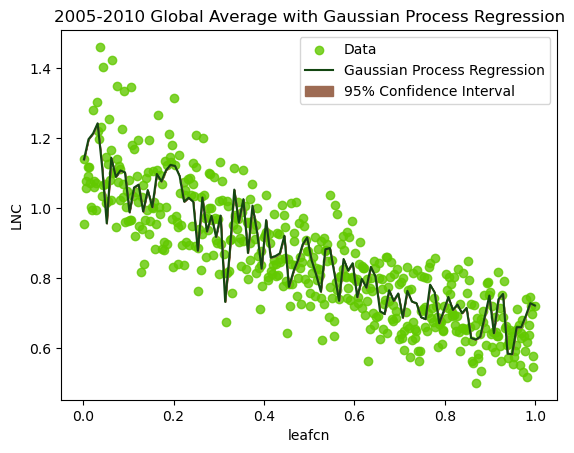

In [46]:
plot_gpr('leafcn', 'LNC')

In [51]:
def plot_gpr(param, var):
    '''Describe the relationship between the selected variable 
    and parameter(s) between 2005-2010. Output a
    cluster plot averaged by year with Gaussian Process Regression.'''

    # Read in and wrangle user selected parameter cluster
    param_avg = params[param]

    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations(var)
    # Feb. ncar time bug
    da = fix_time(da_v)
    # Convert xr.ds to xr.da
    da = da[var]
    # Weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # Weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # Take global avg for variable over year dimension
    var_avg = da_global_ann.mean(dim='year')

    # Prepare data for GPR
    X = param_avg.values.reshape(-1, 1)  # Reshape to column vector
    y = var_avg.values

    # Define the kernel for GPR
    kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))

    # Initialize and fit Gaussian Process Regression model
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gpr.fit(X, y)

    # Generate data for plotting GPR predictions
    x_pred = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
    y_pred, sigma = gpr.predict(x_pred, return_std=True)

    # Plotting
    plt.scatter(x=param_avg, y=var_avg, color='#62c900ff', alpha=0.8, label='Observations')
    plt.plot(x_pred, y_pred, color='#134611', label='GPR Prediction')
    
    # 95% confidence interval
    # cumulative distribution function (CDF) of a standard normal distribution at z score = 1.96
    plt.fill_between(x_pred.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='#9d6b53', alpha=0.8) 
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel(var)
    plt.title('2005-2010 Global Average with Gaussian Process Regression')

    # Show legend with confidence interval
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1), labels=['Data', 'Gaussian Process Regression', '95% Confidence Interval'])

    # Show the plot
    plt.show()

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


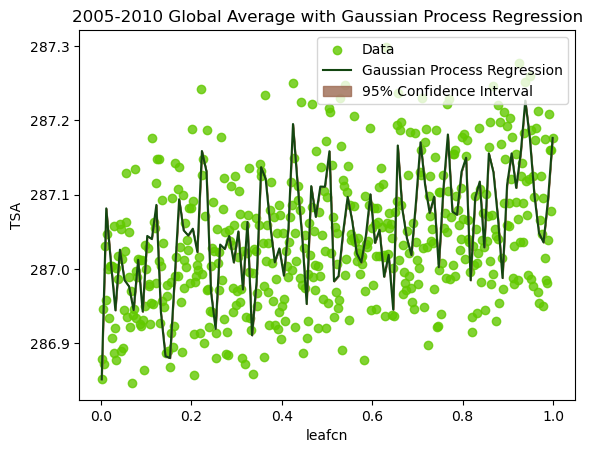

In [52]:
plot_gpr('leafcn', 'TSA')

An attempt to reduce overfitting issues

In [67]:
def subset_and_plot_gpr(param, var):
    '''describe the relationship between the selected variable 
    and parameter(s) over the selected period of time. output a
    best fit line of regression.'''
    
     # Read in and wrangle user selected parameter cluster
    param_avg  = params[param]

    
    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations(var)
    # feb. ncar time bug
    da = fix_time(da_v)
    # convert xr.ds to xr.da
    da = da[var]
    # weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # Take global avg for variable over year dimension
    var_avg = da_global_ann.mean(dim='year')

    # Plotting
    plt.scatter(x=param_avg, y=var_avg, color = '#62c900ff', alpha = 0.8)
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel(var)
    plt.title('2005-2010 Global Average')


    # Gaussian Process Regression
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    X = var_avg.values.reshape(-1, 1)
    y = param_avg.values
    gpr.fit(X, y)
    x_pred = np.linspace(0, 1, 100).reshape(-1, 1)
    y_pred, sigma = gpr.predict(x_pred, return_std=True)
    plt.plot(x_pred, y_pred, '#134611', label='Gaussian Process Regression')
    plt.fill_between(x_pred.flatten(), y_pred - sigma, y_pred + sigma, alpha=0.2, color='#9d6b53')

    # Show legend with confidence interval
    plt.legend(loc='upper right',  bbox_to_anchor=(1, 1), labels=['Data', 'Gaussian Process Regression', '95% Confidence Interval'])


    # Show the plot
    plt.show()

Adding 95% confidence interval label in legend and trying to correct for overfitting

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


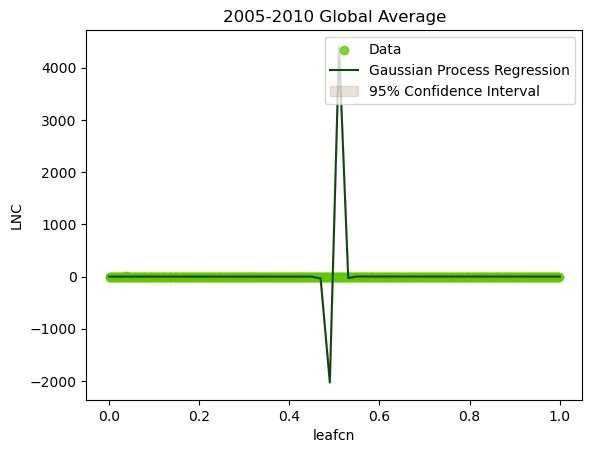

In [68]:
# Example usage:
subset_and_plot_gpr('leafcn', 'LNC')

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


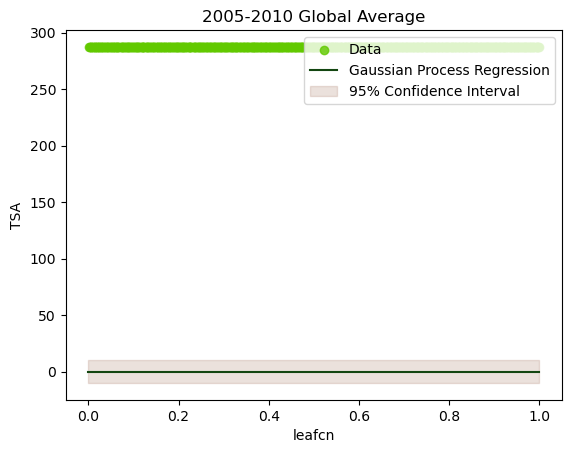

In [69]:
subset_and_plot_gpr('leafcn', 'TSA')

In [72]:
def subset_and_plot_gpr(param, var):
    '''Describe the relationship between the selected variable 
    and parameter(s) over the selected period of time. Output a
    best fit line of regression.'''
    
    # Read in and wrangle user selected parameter cluster
    param_avg = params[param]

    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations(var)
    # Feb. ncar time bug
    da = fix_time(da_v)
    # Convert xr.ds to xr.da
    da = da[var]
    # Weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # Weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # Take global avg for variable over year dimension
    var_avg = da_global_ann.mean(dim='year')

    # Data Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(var_avg.values.reshape(-1, 1))

    # Plotting
    plt.scatter(x=param_avg, y=var_avg, color='#62c900ff', alpha=0.8)
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel(var)
    plt.title('2005-2010 Global Average')

    # Gaussian Process Regression
    # model the noise in the data
    kernel = 1.0 * RBF(length_scale=1.0) + WhiteKernel(noise_level=1e-5)
    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    gpr.fit(X_scaled, param_avg)

    # Generate data for plotting GPR predictions within the range [0, 1]
    x_pred_scaled = np.linspace(X_scaled.min(), X_scaled.max(), 100).reshape(-1, 1)
    x_pred = scaler.inverse_transform(x_pred_scaled)  # Inverse transform to original scale
    y_pred, sigma = gpr.predict(x_pred_scaled, return_std=True)
    plt.plot(x_pred, y_pred, color='#134611', label='Gaussian Process Regression')
    plt.fill_between(x_pred.flatten(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='#9d6b53')

    # Show legend with confidence interval
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1), labels=['Data', 'Gaussian Process Regression', '95% Confidence Interval'])

    # Show the plot
    plt.show()

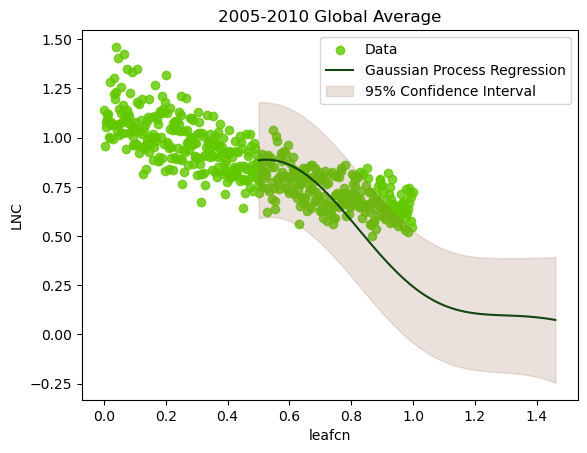

In [73]:
# Example usage:
subset_and_plot_gpr('leafcn', 'LNC')

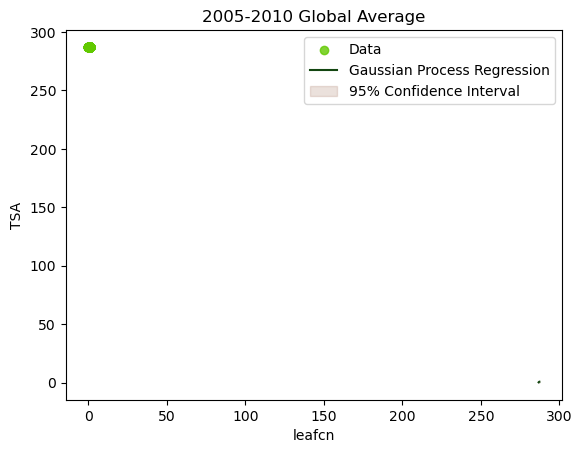

In [74]:
# Example usage:
subset_and_plot_gpr('leafcn', 'TSA')

In [83]:
def subset_and_plot_gpr(param, var):
    '''describe the relationship between the selected variable 
    and parameter(s) over the selected period of time. output a
    best fit line of regression.'''
    
    # Read in and wrangle user selected parameter cluster
    param_avg = params[param]

    # Read in and wrangle user selected variable cluster
    da_v = read_all_simulations(var)
    # Feb. ncar time bug
    da = fix_time(da_v)
    # Convert xr.ds to xr.da
    da = da[var]
    # Weight gridcell dim by global land area
    da_global = weight_landarea_gridcells(da, landarea)
    # Weight time dim by days in month
    da_global_ann = yearly_weighted_average(da_global)
    # Take global avg for variable over year dimension
    var_avg = da_global_ann.mean(dim='year')

    # Plotting
    plt.scatter(x=param_avg, y=var_avg, color = '#62c900ff', alpha = 0.8)
    # Set plot labels and title
    plt.xlabel(param)
    plt.ylabel(var)
    plt.title('2005-2010 Global Average')

    # Gaussian Process Regression
    kernel = C(1.0, (1e-2, 1e2)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)
    X = param_avg.values.reshape(-1, 1)
    y = var_avg.values
    gp.fit(X, y)
    x_pred = np.linspace(0, 1, 100).reshape(-1, 1)
    y_pred, sigma = gp.predict(x_pred, return_std=True)
    plt.plot(x_pred, y_pred, '#134611', label='Gaussian Process Regression')
    plt.fill_between(x_pred.flatten(), y_pred - sigma, y_pred + sigma, alpha=0.2, color='#9d6b53')

    # Show legend with confidence interval
    plt.legend(loc='upper right',  bbox_to_anchor=(1, 1), labels=['Data', 'Gaussian Process Regression', '95% Confidence Interval'])


    # Show the plot
    plt.show()

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:434: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


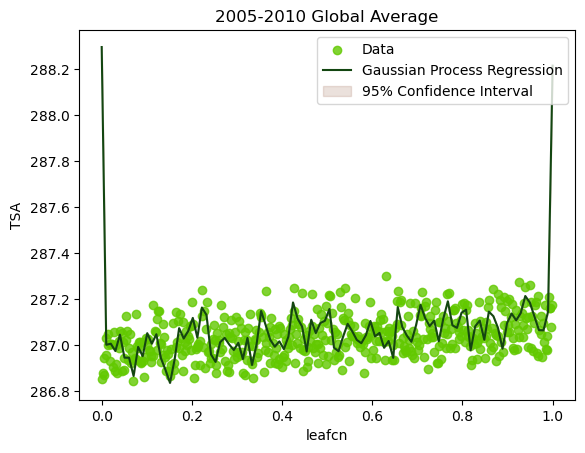

In [84]:
# Example usage:
subset_and_plot_gpr('leafcn', 'TSA')

## Linear Regression


In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_train, x_test, y_train, y_test = train_test_split(leafcn, 
                                                    lnc, 
                                                    test_size = 0.20,
                                                    random_state=0)

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Linear Regression       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
regressor = LinearRegression()
regressor.fit(leafcn, lnc)

In [ ]:
# Assuming leafcn_da and LNC_da are your pre-processed data arrays
# Make sure that leafcn_da and LNC_da have the same length and are 1D arrays
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Split Data 90/10        ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_train, x_test, y_train, y_test = train_test_split(leafcn, lnc, test_size=0.1, random_state=0)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----      Linear Regression       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
regressor = LinearRegression()
regressor.fit(x_train, y_train)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----       Make Predictions       ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
y_pred = regressor.predict(x_test)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ----    Plot Linear Regression    ----
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
plt.scatter(x_train, y_train, color='g', label='Training Data')
plt.scatter(x_test, y_test_, color='b', label='Testing Data')
plt.plot(x_test, y_pred, color='k', linewidth=2, label='Linear Regression')

plt.xlabel('Leaf Carbon Nitrogen Ratio')
plt.ylabel('Leaf Nitrogen Concentration')
plt.title("Linear Regression of f{'var'} vs f{'param'}")
plt.legend()
plt.show()